# Conformal matrix completion with weighted sampling

This notebook investigates conformal matrix completion with weighted sampling. The goal is to:
1. Define a reasonable way to construct weight functions to sample the observation sets. Show the standard conformal prediction set fails to achieve the marginal covetage under the weighted sampling model. 
2. Show by experiments that weighted conformal prediction intervals are robust to covariate shift in the sense that they provide valid marginal coverage for the biased sampling scheme. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from tqdm import tqdm

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *  

(CVXPY) May 08 10:12:18 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


In [4]:
import math
from tqdm import tqdm
from time import time
import pdb

## Weighted model 1
For the model outline and method details, refer to Section 5.3 in the CMC Overleaf draft.
In this setting, we consider $w_1(I_i) = \frac{i}{N}$ where $N$ is the total number of entries in the matrix, and $w_2(I_i)=\frac{1}{n_{\text{test}}}$. Roughly speaking, observations are sampled with a probability proportional to the index value and test points are uniformly sampled from the missing entries.

In [5]:
# Define experiment parameters
m, n, r = 200,200,20
prop_obs = 0.5
alpha = 0.1
random_state = 0

In [6]:
# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 0.7
w = np.arange(1, m*n+1)**scale/(m*n)
w = w/sum(w)

Sampling with weight from the noiseless random factorization model... 

Dark spots indicating the missing entries.


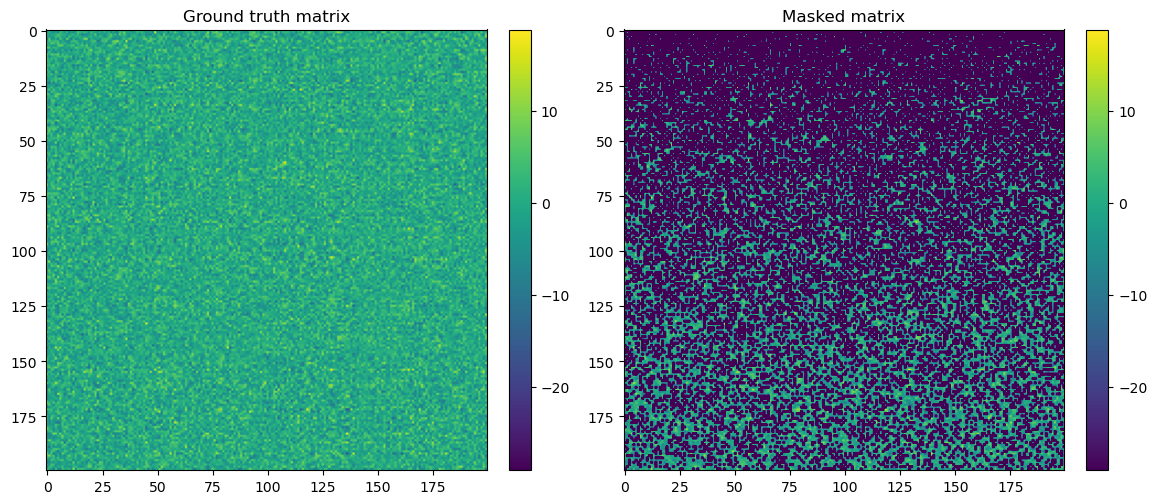

Observation size: 20000, training size: 16000, calib size: 4000


In [7]:
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

print('Sampling with weight from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
sampler = RandomSampling(m, n)
obs = sampler.sample_observed(prop_obs, w=w, random_state=10)
test = np.ones_like(obs) - obs
train, calib = sampler.sample_train_calib(obs, calib_size=0.2*np.sum(obs), 
                                            random_state = random_state)
assert np.sum(train+calib==obs) == m*n,'Sampling error!'
vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}"
      .format(np.sum(obs), np.sum(train), np.sum(calib)))

In [8]:
print("Weighted sampling\n"+"-"*25)
print('Solving matrix completion with PMF...')
Mhat, U, VT = pmf_solve(M, train, k=r, random_state=random_state, verbose=True)
test_mse = evaluate_mse(M, Mhat, test)
train_mse = evaluate_mse(M, Mhat, train)
calib_mse = evaluate_mse(M, Mhat, calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Weighted sampling
-------------------------
Solving matrix completion with PMF...
Iteration: 1; Mean diff: 0.0029
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Stopping criteria met, training terminated.
train MSE: 9.0486083321584e-07, calib MSE: 0.028239450800871528, test MSE: 0.6449604123475725


Weighted sampling
-------------------------


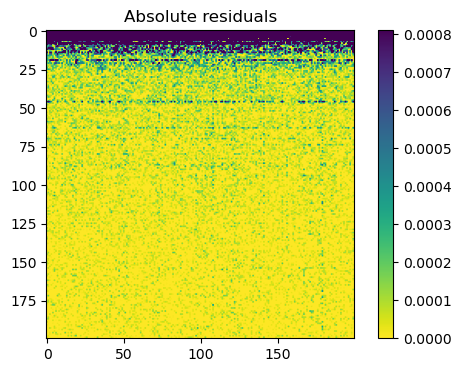

In [9]:
print("Weighted sampling\n"+"-"*25)
error_heatmap(M, Mhat, test)
#residual_hist(M, Mhat, train, calib, test)

## Experiments

We conduct some experiments with the toy models and compute the conformal prediction intervals for test points with the simplest scores based on estimation residuals for both exchangeble settings and covariate shift settings.

### Experiment 1: Fixing M, resample train, test, calib sets

In [10]:
def run_single_experiment(M, w_obs, w_test, train_mask, test_mask, calib_mask, alpha, 
                          r= None, verbose=True, random_state=0):
    # Sanity check
    assert all(((train_mask + test_mask + calib_mask) <= 1).flatten()),\
           'Found error in sampling process, make sure splitted sets are disjoint'
    
    if verbose:
        print("Running matrix completion algorithm on the training set...")
    Mhat, U, VT = pmf_solve(M, train_mask, k=r, verbose=verbose, random_state=random_state)
    if verbose:
        print("Done training!")
        
    M_flat = M.flatten(order='C')
    cpi = Conformal_PI(M, Mhat, train_mask, calib_mask)
    test_idxs = np.where(test_mask.flatten(order='C')== 1)[0]
    
    spi = cpi.standard_PI(test_idxs, alpha)
    wpi = cpi.weighted_PI(test_idxs, w_obs, w_test, alpha, allow_inf=True)
    non_inf= [i for i in range(len(wpi)) if wpi[i]!=[-np.inf, np.inf]]
        
    calib_mse = evaluate_mse(M, Mhat, calib_mask)
    train_mse = evaluate_mse(M, Mhat, train_mask)
    test_mse = evaluate_mse(M, Mhat, test_mask)
    
    results = evaluate_PI(spi, M_flat[test_idxs], label="standard")
    results = pd.concat([results, evaluate_PI(wpi, M_flat[test_idxs], label="inf")], axis=1)
    results = pd.concat([results, evaluate_PI(np.array(wpi)[non_inf], M_flat[test_idxs[non_inf]], label="noinf")], axis=1)
    results['inf_prop'] = [1-len(non_inf)/len(test_idxs)]
    results['Calib_MSE'] = [calib_mse]
    results['Train_MSE'] = [train_mse]
    results['Test_MSE'] = [test_mse]
    results['Alpha'] = [alpha]
    results['Seed'] = [random_state]
    results['Calib_size'] = [np.sum(calib_mask)]
    results['Train_size'] = [np.sum(train_mask)]
    results['Test_size'] = [len(test_idxs)]
    
    # If the true rank or an estimation is given, approximate the minimal sufficient sample size 
    # for exact coverage.
    if r:
        results['Theory_size'] = [theoretical_bound(M.shape[0], M.shape[1], r, C=1)]
    return results

In [27]:
# Define experiment parameters
m, n, r = 400,400,20
prop_obs = 0.2
alpha = 0.1
repetition = 1

In [28]:
theoretical_bound(m, n, r, C=1)

214358.0

print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)
results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    random_state = i
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs = sampler.sample_observed(prop_obs, random_state=random_state)
    test = np.ones_like(obs) - obs
    train, calib = sampler.sample_train_calib(obs, prob_calib=0.2, 
                                            random_state = random_state)
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    res = run_single_experiment(M, train, test, calib, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results = pd.concat([results, res])

print("Uniform sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results['Calib_size'].iloc[0], 
              results['Train_size'].iloc[0], results['Theory_size'].iloc[0]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

In [29]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.2
w_obs = np.arange(1, m*n+1)**scale/(m*n)
w_obs = w_obs/sum(w_obs)

w_test = np.ones(m*n)
w_test = w_test/sum(w_test)
assert all(w_obs >= 0) and all(w_test >= 0), "Error in weights generation!"

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



In [30]:
results_w = pd.DataFrame({})

for i in tqdm(range(repetition), desc="Repetitions", leave=True, position=0):
    random_state = i
    
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs = sampler.sample_observed(prop_obs, w=w_obs, random_state=random_state)
    test = np.ones_like(obs) - obs
    
    n_calib = np.min([4000, int(0.2*np.sum(obs))])
    train, calib = sampler.sample_train_calib(obs, calib_size=n_calib, 
                                                random_state = random_state)
    print("Training size:{}, calib size: {}, test size: {}".format(np.sum(train), np.sum(calib), np.sum(test)))
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    res = run_single_experiment(M, w_obs, w_test, train, test, calib, alpha, 
                          r= r, verbose=True, random_state=i)
    
    results_w = pd.concat([results_w, res])

Repetitions:   0%|                                                                               | 0/1 [00:00<?, ?it/s]

Training size:28000, calib size: 4000, test size: 128000
Running matrix completion algorithm on the training set...
Iteration: 1; Mean diff: 0.0031
Iteration: 2; Mean diff: 0.0000
Iteration: 3; Mean diff: 0.0000
Iteration: 4; Mean diff: 0.0000
Iteration: 5; Mean diff: 0.0000
Iteration: 6; Mean diff: 0.0000
Stopping criteria met, training terminated.
Done training!
Computing standard marginal prediction intervals for 128000 test points...


SPI: 100%|█████████████████████████████████████████████████████████████████| 128000/128000 [00:00<00:00, 276597.43it/s]


Computing weighted prediction intervals for 128000 test points...


Repetitions: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [04:08<00:00, 248.42s/it]


Weighted sampling
-------------------------
Test size is 128000, calibration size is 4000, training size is 28000, theoretical minimum training size is 214358.0


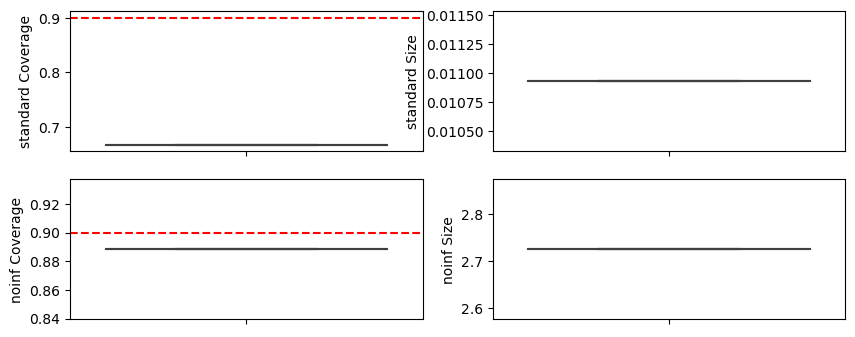

In [31]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results_w['Calib_size'].iloc[0], 
              results_w['Train_size'].iloc[0], results_w['Theory_size'].iloc[0]))

fig, axs = plt.subplots(2,2, figsize=(10,4))
sns.boxplot(y="standardCoverage", data=results_w, ax=axs[0,0])
axs[0,0].set(ylabel='standard Coverage')
axs[0,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="standardSize", data=results_w, ax=axs[0,1])
axs[0,1].set(ylabel='standard Size')

sns.boxplot(y="noinfCoverage", data=results_w, ax=axs[1,0])
axs[1,0].set(ylabel='noinf Coverage')
axs[1,0].axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="noinfSize", data=results_w, ax=axs[1,1])
axs[1,1].set(ylabel='noinf Size')
plt.show()

In [32]:
results_w

,standardCoverage,standardSize,infCoverage,infSize,noinfCoverage,noinfSize,inf_prop,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Test_size,Theory_size
0,0.667937,0.010932,0.88882,inf,0.888334,2.724881,0.004352,0.150814,0.000002,1.966661,0.1,0,4000,28000,128000,214358.0


In [44]:
results

,Coverage,Size,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Theory_size
0,0.888,0.003361,0.000001,4.592818e-07,0.000001,0.1,0,1200,4800,11651.0


In [22]:
pi

3.141592653589793

In [23]:
Mhat

array([[-2.31604583e+00,  1.73086983e+00,  4.38901823e+00, ...,
        -7.57477625e-01,  4.77323622e-01,  6.99327997e-01],
       [ 4.63597714e+00, -1.81767364e+00, -4.22699855e+00, ...,
         7.92808645e-02, -9.65623223e-01, -3.49146943e+00],
       [-2.55494784e+00,  2.27018941e+00,  3.24836754e+00, ...,
        -1.29311355e+00,  1.54582001e+00,  4.19514550e+00],
       ...,
       [-2.37784070e+00, -1.54603636e+00, -3.19085817e-01, ...,
         1.52083556e+00,  1.69431206e-01, -2.37578154e+00],
       [ 8.25615910e-01, -1.56191716e+00, -1.74540872e+00, ...,
         1.65648662e-01, -1.96658456e+00, -9.38872595e-01],
       [ 3.57050932e+00,  4.76401516e-04, -4.01477644e-01, ...,
        -1.20371930e+00, -1.87739472e+00, -1.34023006e+00]])

In [44]:
test = np.array([1,0,2])

In [45]:
any(test == 0)

True

In [48]:
try:
    test = np.emath.logn(2,0)
except:
    test = 1

In [49]:
test

-inf

In [50]:
np.inf

inf